In [1]:
import sys, os
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
import math

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(0)

MAX_LEN = 64

In [2]:
def adjust_lr(optimizer, epoch):
    if epoch >= 2:
        lr = 2e-5
    else:
        lr = 1e-6
        
    lr *= 4

    optimizer.param_groups[0]['lr'] = lr
    optimizer.param_groups[1]['lr'] = 100*lr
    
    if epoch == 0:
        optimizer.param_groups[0]['lr'] = 0
        optimizer.param_groups[1]['lr'] = 0.2       
    
    return lr


def get_optimizer(net):
    params = [x[1] for x in filter(lambda kv: "backbone" in kv[0], net.named_parameters())]
    arc_weight = [x[1] for x in filter(lambda kv: "backbone" not in kv[0], net.named_parameters())]

    optimizer = torch.optim.Adam([{"params": params}, {"params": arc_weight}], lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-08)
    return optimizer

In [3]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        
        self.ls_eps = ls_eps
        self.arc_weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.arc_weight)

        self.easy_margin = easy_margin
        self.set_margin(margin)
        
    def set_margin(self, margin):
        self.margin = margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        
        self.th = nn.Parameter(torch.FloatTensor([math.cos(math.pi - margin)]), requires_grad=False)
        self.mm = nn.Parameter(torch.FloatTensor([math.sin(math.pi - margin) * margin]), requires_grad=False)

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.arc_weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = label #torch.zeros(cosine.size(), device='cuda')
        #one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output

In [4]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForMaskedLM, AutoModel


class TrainingModel(nn.Module):
    def __init__(self, model, num_classes):
        super(TrainingModel, self).__init__()
        self.model = model
        self.arcface = ArcMarginProduct(1024, num_classes, scale=20.0, margin=0.1)

    def forward(self, ids, mask, label):
        x = self.model(ids, mask)
        return self.arcface(x, label)

    
class VecModel(nn.Module):
    def __init__(self, model_name):
        super(VecModel, self).__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        print(self.backbone)
        self.bn = nn.BatchNorm1d(1024)
        self.top = nn.Linear(1024, 1024)

    def forward(self, ids, mask):
        out = self.backbone(ids, mask)[0]
        out = (out[:, 1:MAX_LEN//2, :]*mask[:, 1:MAX_LEN//2, None]).mean(axis=1)
        
        return F.normalize(self.top(self.bn(out)))

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path, map_location='cpu'))

In [5]:
corr_df = pd.read_csv("data/correlations.csv")

corr_df["content_ids"] = corr_df["content_ids"].apply(lambda x: x.split())

corr_df = corr_df.explode('content_ids').reset_index(drop=True)
corr_df

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d
1,t_00004da3a1b2,c_376c5a8eb028
2,t_00004da3a1b2,c_5bc0e1e2cba0
3,t_00004da3a1b2,c_76231f9d0b5e
4,t_00068291e9a4,c_639ea2ef9c95
...,...,...
279914,t_fff9e5407d13,c_d64037a72376
279915,t_fffbe1d5d43c,c_46f852a49c08
279916,t_fffbe1d5d43c,c_6659207b25d5
279917,t_fffe14f1be1e,c_cece166bad6a


In [6]:
topic_df = pd.read_csv("data/topics.csv")
topic_df["title"] = topic_df["title"].fillna("")

title_map = topic_df.set_index("id")["title"].to_dict()
parent_map = topic_df.set_index("id")["parent"].to_dict()

topic_df = topic_df[topic_df["has_content"]].reset_index(drop=True)
print(topic_df.shape)

topic_df["parent_title"] = topic_df["parent"].apply(lambda x: title_map.get(x, ""))
print(topic_df.shape)

topic_df["grandpa"] = topic_df["parent"].apply(lambda x: parent_map.get(x))
topic_df["grandpa_title"] = topic_df["grandpa"].apply(lambda x: title_map.get(x, ""))
print(topic_df.shape)

topic_df["ggrandpa"] = topic_df["grandpa"].apply(lambda x: parent_map.get(x))
topic_df["ggrandpa_title"] = topic_df["ggrandpa"].apply(lambda x: title_map.get(x, ""))
print(topic_df.shape)

topic_df["title"] = topic_df["title"] + " @ " + topic_df["parent_title"] + " @ " + topic_df["grandpa_title"] + " @ " + topic_df["ggrandpa_title"]

topic_df.head()

(61517, 9)
(61517, 10)
(61517, 12)
(61517, 14)


,id,title,description,channel,category,level,language,parent,has_content,parent_title,grandpa,grandpa_title,ggrandpa,ggrandpa_title
0,t_00004da3a1b2,Откриването на резисторите @ Открития и проект...,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True,Открития и проекти,t_c85886762db7,Физика,t_27a0a3c7ee9a,Наука
1,t_00068291e9a4,Entradas e saídas de uma função @ Álgebra: fun...,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True,Álgebra: funções,t_461c9a8dd863,9º Ano,t_a6420bcff569,Matemática por ano (Alinhada à BNCC)
2,t_00069b63a70a,Transcripts @ Flow Charts: Logical Thinking? @...,NaN,6e3ba4,source,3,en,t_4054df11a74e,True,Flow Charts: Logical Thinking?,t_acbbd893e6af,Engineering,t_9c5f09334d83,MIT Blossoms
3,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True,Показателни и логаритмични функции,t_5f4cc8e02423,Алгебра (цялото съдържание),t_afd8db5e4f44,Математика
4,t_0008768bdee6,100 સુધીનો સરવાળો @ 100 સુધીના સરવાળા અને બાદબ...,37 અને 49 જેવી બે-અંકની સંખ્યાઓ ઉમેરતા શીખો.,5223e0,supplemental,4,gu,t_0da7a331d666,True,100 સુધીના સરવાળા અને બાદબાકી,t_d20fc01fdf38,પ્રારંભિક ગણિત,t_38bca5075c51,ધોરણ ૩


In [7]:
from sklearn.model_selection import KFold


N_FOLDS = 3

splits = KFold(N_FOLDS, shuffle=True, random_state=0).split(topic_df, topic_df["has_content"])

topic_df["fold"] = 0

for f, (train_ind, val_ind) in enumerate(splits):
    topic_df.loc[val_ind, "fold"] = f

topic_df["fold"].value_counts()

0    20506
1    20506
2    20505
Name: fold, dtype: int64

In [8]:
topic_df.loc[(topic_df["category"] == "source") | (topic_df["fold"] > 0), "fold"] = 1
topic_df["fold"].value_counts()

1    53269
0     8248
Name: fold, dtype: int64

In [9]:
le_topic = LabelEncoder()
topic_df["t"] = topic_df["title"].fillna("") + " | " + topic_df["description"].fillna("")

In [10]:
TEST_FOLD = 0

topic_df  = topic_df[topic_df["language"] != "ar"]

topic_df["sw"] = 1

topic_df_test = topic_df[topic_df["fold"] == TEST_FOLD].reset_index(drop=True)
topic_df_train = topic_df[topic_df["fold"] != TEST_FOLD].reset_index(drop=True)



topic_df_train["label"] = le_topic.fit_transform(topic_df_train["t"])


topic_df_train.shape, topic_df_test.shape, len(le_topic.classes_)

((50096, 18), (8248, 17), 48474)

In [11]:
content_df = pd.read_csv("data/content.csv")

content_df  = content_df[content_df["language"] != "ar"]

content_df.loc[content_df["title"] == content_df["description"], "description"] = None
content_df["description"].fillna(content_df["text"].fillna("").apply(lambda x: x[:256]), inplace=True)
content_df["t"] = content_df["title"].fillna("") + " | " + content_df["description"].fillna("")

print(content_df.shape)
content_df.head()

(146629, 9)


,id,title,description,kind,text,language,copyright_holder,license,t
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN,"Sumar números de varios dígitos: 48,029+233,93..."
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN,Trovare i fattori di un numero | Sal trova i f...
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN,Sumar curvas de demanda | Cómo añadir curvas d...
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND,Nado de aproximação | Neste vídeo você vai apr...
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,Estándares Comunes del Estado de Nueva York\n\...,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA,geometry-m3-topic-a-overview.pdf | Estándares ...


In [12]:
train_contents = corr_df.merge(topic_df_train[["id"]], left_on="topic_id", right_on="id")
train_contents["sw"] = 1
train_contents["sw"] /= np.sqrt(train_contents.groupby("topic_id")["id"].transform("count"))

train_contents = train_contents.groupby("content_ids")["sw"].sum().reset_index()
train_contents["sw"] = train_contents["sw"].clip(0.1, 10)

train_contents.rename(columns={"content_ids": "id"}, inplace=True)
train_contents["is_train"] = True
train_contents["sw"] = train_contents.shape[0]*train_contents["sw"]/train_contents["sw"].sum()
train_contents.shape

(133704, 3)

In [13]:
train_contents.sort_values("sw")

,id,sw,is_train
44128,c_545acb0266dc,0.13621,True
126381,c_f1d00a890741,0.13621,True
22196,c_2a5f21e7c6a4,0.13621,True
98949,c_bd0650b611ce,0.13621,True
80426,c_99f74efe3b8b,0.13621,True
...,...,...,...
82813,c_9e535853b1c5,13.62097,True
45932,c_57d5544dba1f,13.62097,True
54547,c_6876bcfd56de,13.62097,True
51950,c_63629624ee82,13.62097,True


In [14]:
content_df = content_df.merge(train_contents, on="id", how="left")
content_df["is_train"].fillna(False, inplace=True)
content_df["sw"].fillna(1.0, inplace=True)

content_df["is_train"].mean()

0.9115250052854483

In [15]:
#corr_df["label"] = le_topic.transform(corr_df["topic_id"])
corr_df = corr_df.merge(topic_df_train[["id", "label"]].rename(columns={"id": "topic_id"}), on="topic_id")


content_labels = corr_df.groupby("content_ids").agg({"label": list}).reset_index()
content_labels = content_labels.rename(columns={"content_ids": "id"})
content_labels["label"] = content_labels["label"].apply(lambda x: list(set(x)))

topic_df_train["label"] = topic_df_train["label"].apply(lambda x: [x])
topic_df_test["label"] = 0
topic_df_test["label"] = topic_df_test["label"].apply(lambda x: [x])

content_labels

,id,label
0,c_00002381196d,"[34530, 34425, 34426, 34427, 34428]"
1,c_000087304a9e,"[14304, 14305]"
2,c_0000ad142ddb,[12204]
3,c_0000c03adc8d,[29213]
4,c_00016694ea2a,"[26408, 40517]"
...,...,...
133699,c_fffcbdd4de8b,[1813]
133700,c_fffe15a2d069,"[18316, 18317, 18318, 34043, 34044, 34045]"
133701,c_fffed7b0d13a,"[27256, 27257, 27258]"
133702,c_ffff04ba7ac7,[2668]


In [16]:
print(content_df.shape)

content_df = content_df.merge(content_labels, on="id", how="left")
content_df.loc[~content_df["is_train"], "label"] = 0
content_df.loc[~content_df["is_train"], "label"] = content_df.loc[~content_df["is_train"], "label"].apply(lambda x: [x])

content_df

(146629, 11)


,id,title,description,kind,text,language,copyright_holder,license,t,sw,is_train,label
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN,"Sumar números de varios dígitos: 48,029+233,93...",2.482370,True,"[34530, 34425, 34426, 34427, 34428]"
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN,Trovare i fattori di un numero | Sal trova i f...,1.362097,True,"[14304, 14305]"
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN,Sumar curvas de demanda | Cómo añadir curvas d...,0.786407,True,[12204]
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND,Nado de aproximação | Neste vídeo você vai apr...,0.393204,True,[29213]
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,Estándares Comunes del Estado de Nueva York\n\...,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA,geometry-m3-topic-a-overview.pdf | Estándares ...,1.666671,True,"[26408, 40517]"
...,...,...,...,...,...,...,...,...,...,...,...,...
146624,c_fffcbdd4de8b,2. 12: Diffusion,What will eventually happen to these dyes?\n\n...,html5,What will eventually happen to these dyes?\n\n...,en,CSU and Merlot,CC BY-NC-SA,2. 12: Diffusion | What will eventually happen...,0.312486,True,[1813]
146625,c_fffe15a2d069,Sommare facendo gruppi da 10,Sal somma 5+68 spezzando il 5 in un 2 e un 3.\n\n,video,NaN,it,NaN,NaN,Sommare facendo gruppi da 10 | Sal somma 5+68 ...,2.889444,True,"[18316, 18317, 18318, 34043, 34044, 34045]"
146626,c_fffed7b0d13a,Introdução à subtração,Sal fala sobre o que significa subtrair. Os ex...,video,NaN,pt,NaN,NaN,Introdução à subtração | Sal fala sobre o que ...,1.918171,True,"[27256, 27257, 27258]"
146627,c_ffff04ba7ac7,SA of a Cone,,video,NaN,en,NaN,NaN,SA of a Cone |,0.556074,True,[2668]


In [17]:
MODEL_NAME = "xlm-roberta-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)

In [18]:
NW = 8
BS = 64

class LECRDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512, aug=False):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.mask_token = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)
        self.aug = aug
        self.num_classes = len(le_topic.classes_)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        encoding = self.tokenizer(str(row.t), return_offsets_mapping=True,
                                  padding='max_length', truncation=True, max_length=self.max_len)

        encoding = {key: torch.as_tensor(val) for key, val in encoding.items()}

        if self.aug:
            ix = torch.rand(size=(self.max_len,)) < 0.15
            encoding["input_ids"][ix] = self.mask_token
            
        target = torch.zeros(self.num_classes, dtype=torch.float32)
        for l in row.label:
            target[l] = 1/len(row.label)
        
        return encoding, target, torch.FloatTensor([row.sw])
    
    




vec_model = VecModel(MODEL_NAME)
model = TrainingModel(vec_model, num_classes=len(le_topic.classes_))
model = model.cuda()

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLMRobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(250002, 1024, padding_idx=1)
    (position_embeddings): Embedding(514, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          

In [19]:
from sklearn.neighbors import NearestNeighbors


def to_vec(model, ds):
    val_loader = DataLoader(ds, batch_size=BS, shuffle=False, num_workers=NW,
                             pin_memory=False, drop_last=False)
    
    model.eval()

    tbar = tqdm(val_loader, file=sys.stdout)

    vectors = []

    with torch.no_grad():
        for idx, (data, target, _) in enumerate(tbar):
            ids, mask, target = data["input_ids"].cuda(), data["attention_mask"].cuda(), target.cuda()

            vec = model.model(ids, mask)
            vectors.append(vec.detach().cpu().numpy())

    V = np.concatenate(vectors)
    
    return V



def get_matches(V_topic, V_content, topic_ids, content_ids, n_neighbors=5):
    
    neighbors_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', n_jobs=-1)
    neighbors_model.fit(V_content)
    dists, indices = neighbors_model.kneighbors(V_topic)
    
    res_df = pd.DataFrame({"topic_id": np.repeat(topic_ids, n_neighbors),
                           'content_id': content_ids[indices.ravel()],
                           'vec_dist': dists.ravel()
                          })
    return res_df


def f2(recall, precision):
    return 5*precision*recall/(4*precision + recall)

def metric(pred_df):
    scores = np.zeros(pred_df.shape[0])

    for i, (gt, pred) in enumerate(zip(pred_df["content_ids"].values, pred_df["pred"].values)):
        hits = 0

        gt, pred = gt.split(), pred.split()

        for l in gt:
            if l in pred:
                hits += 1

        if hits > 0:           
            recall = hits / len(gt)
            precision = hits / len(pred)

            scores[i] = f2(recall, precision)

    return scores.mean()
    

def evaluate(topic_df, content_df):    
    topic_ds = LECRDataset(topic_df, tokenizer, MAX_LEN, aug=False)
    content_ds = LECRDataset(content_df, tokenizer, MAX_LEN, aug=False)


    V_topic = to_vec(model, topic_ds)
    V_content = to_vec(model, content_ds)

    res_df = get_matches(V_topic, V_content, topic_df["id"].values, content_df["id"].values)

    res_df["rank"] = res_df.groupby("topic_id")["vec_dist"].rank(method="first", ascending=True)

    pred_df = res_df.copy() #res_df[(res_df["rank"] == 1) | (res_df["vec_dist"] < 0.1)]
    pred_df = pred_df.groupby("topic_id")["content_id"].apply(lambda x: " ".join(list(x)))
    pred_df = pred_df.reset_index().rename(columns={"content_id": 'pred'})
    pred_df = pred_df.merge(pd.read_csv("data/correlations.csv"), on="topic_id")

    return metric(pred_df)

In [20]:
def cross_entropy(pred, soft_targets, sw):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1)*sw)


def train(model, epochs=2, n_batches=1, dynamic_margin=True):
    train_df = topic_df_train.append(content_df[content_df["is_train"]]).reset_index(drop=True)
    train_ds = LECRDataset(train_df, tokenizer, MAX_LEN, aug=False)

    train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW,
                               pin_memory=False, drop_last=True)

    optimizer = get_optimizer(model)

    scaler = torch.cuda.amp.GradScaler()

    for e in range(epochs):
        if dynamic_margin:
            model.arcface.set_margin(0.1 + e*0.02)
        model.cuda()
        model.train()
        tbar = tqdm(train_loader, file=sys.stdout)

        lr = adjust_lr(optimizer, e)

        loss_list, acc_list = [], []

        optimizer.zero_grad()
        for idx, (data, label, sw) in enumerate(tbar):
            ids, mask, label = data["input_ids"].cuda(), data["attention_mask"].cuda(), label.cuda()

            with torch.cuda.amp.autocast():
                preds = model(ids, mask, label)
                loss = cross_entropy(preds, label, sw.cuda())

            loss = loss / n_batches
            scaler.scale(loss).backward()

            if ((idx + 1) % n_batches) == 0:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                
            acc = (preds.softmax(dim=1)*(label > 0)).sum(axis=1).mean()

            loss_list.append(loss.detach().cpu().item())
            acc_list.append(acc.detach().cpu().item())
            avg_loss = np.round(n_batches * np.mean(loss_list), 4)
            avg_acc = np.round(np.mean(acc_list), 2)

            tbar.set_description(f"Epoch {e + 1} Loss: {avg_loss} Acc: {avg_acc} lr: {lr}")

        torch.save(model.state_dict(), "models/tmp.pth")
        log_text = f"Epoch {e+1}\n"
        logfile = open(f"logs/log.txt", 'a')
        logfile.write(log_text)
        logfile.close()
        
        val_score = evaluate(topic_df_test, content_df)
        print("Val score:", val_score)
        print()
        
        
torch.save(model.state_dict(), "models/tmp.pth")
log_text = f"Epoch 0\n"
logfile = open(f"logs/log.txt", 'a')
logfile.write(log_text)
logfile.close()

train(model, epochs=20)

/tmp/ipykernel_4330/2716447418.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = topic_df_train.append(content_df[content_df["is_train"]]).reset_index(drop=True)


Epoch 1 Loss: 9.2159 Acc: 0.02 lr: 4e-06: 100%|█| 2871/2871 [14:44<00:00,  3.25i
100%|███████████████████████████████████████| 2292/2292 [04:25<00:00,  8.62it/s]
Val score: 0.11342475745425834

Epoch 2 Loss: 4.8073 Acc: 0.09 lr: 4e-06: 100%|█| 2871/2871 [14:33<00:00,  3.29i
100%|███████████████████████████████████████| 2292/2292 [04:27<00:00,  8.58it/s]
Val score: 0.27501161713686073

Epoch 3 Loss: 4.7425 Acc: 0.11 lr: 8e-05: 100%|█| 2871/2871 [14:38<00:00,  3.27i
100%|███████████████████████████████████████| 2292/2292 [04:28<00:00,  8.55it/s]
Val score: 0.33917318364416066

Epoch 4 Loss: 3.7868 Acc: 0.18 lr: 8e-05: 100%|█| 2871/2871 [14:36<00:00,  3.27i
100%|███████████████████████████████████████| 2292/2292 [04:28<00:00,  8.54it/s]
Val score: 0.3787861105557553

Epoch 5 Loss: 3.2476 Acc: 0.24 lr: 8e-05: 100%|█| 2871/2871 [14:41<00:00,  3.26i
100%|███████████████████████████████████████| 2292/2292 [04:27<00:00,  8.57it/s]
Val score: 0.41403663807302427

Epoch 6 Loss: 2.8608 Acc: 0.3 l

In [21]:
def adjust_lr(optimizer, epoch):
    if epoch >= 1:
        lr = 8e-6
    else:
        lr = 2e-5

    optimizer.param_groups[0]['lr'] = lr
    optimizer.param_groups[1]['lr'] = 100*lr     
    
    return lr

model.arcface.set_margin(0.5)
train(model, epochs=2, dynamic_margin=False)

/tmp/ipykernel_4330/2716447418.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = topic_df_train.append(content_df[content_df["is_train"]]).reset_index(drop=True)


Epoch 1 Loss: 1.2978 Acc: 0.6 lr: 2e-05: 100%|█| 2871/2871 [14:33<00:00,  3.28it
100%|███████████████████████████████████████| 2292/2292 [04:27<00:00,  8.57it/s]
Val score: 0.5213980823063872

Epoch 2 Loss: 1.1086 Acc: 0.65 lr: 8e-06: 100%|█| 2871/2871 [14:33<00:00,  3.29i
100%|███████████████████████████████████████| 2292/2292 [04:27<00:00,  8.57it/s]
Val score: 0.5214617637564171



In [22]:
model.model.save("models/vec_model_v29large.pth")

In [23]:
topic_ds = LECRDataset(topic_df_test, tokenizer, MAX_LEN, aug=False)
content_ds = LECRDataset(content_df, tokenizer, MAX_LEN, aug=False)


V_topic = to_vec(model, topic_ds)
V_content = to_vec(model, content_ds)

res_df = get_matches(V_topic, V_content, topic_df_test["id"].values, content_df["id"].values,
                    n_neighbors=20)

100%|███████████████████████████████████████| 2292/2292 [04:27<00:00,  8.57it/s]


In [24]:
def best_case_metric(pred_df):
    scores = np.zeros(pred_df.shape[0])

    for i, (gt, pred) in enumerate(zip(pred_df["content_ids"].values, pred_df["pred"].values)):
        hits = 0

        gt, pred = gt.split(), pred.split()

        for l in gt:
            if l in pred:
                hits += 1

        if hits > 0:           
            recall = hits / len(gt)
            precision = 1 #hits / len(pred)

            scores[i] = f2(recall, precision)

    return scores.mean()


pred_df = res_df.groupby("topic_id")["content_id"].apply(lambda x: " ".join(list(x)))
pred_df = pred_df.reset_index().rename(columns={"content_id": 'pred'})
pred_df = pred_df.merge(pd.read_csv("data/correlations.csv"), on="topic_id")

best_case_metric(pred_df)

0.8418138139370968

In [25]:
res_df["rank"] = res_df.groupby("topic_id")["vec_dist"].rank(method="dense")


pred_df = res_df[(res_df["rank"] <= 2) | (res_df["vec_dist"] < 0.3)]
pred_df = pred_df.groupby("topic_id")["content_id"].apply(lambda x: " ".join(list(x)))
pred_df = pred_df.reset_index().rename(columns={"content_id": 'pred'})
pred_df = pred_df.merge(pd.read_csv("data/correlations.csv"), on="topic_id")

metric(pred_df)

0.5565968018460333

<AxesSubplot:>

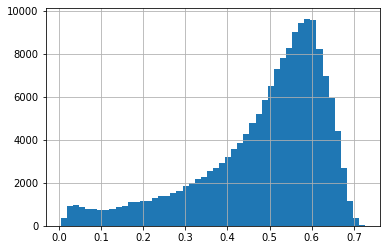

In [26]:
res_df["vec_dist"].hist(bins=50)

In [27]:
x = res_df.merge(content_df[["id", "language"]], left_on="content_id", right_on="id")
x = x.merge(topic_df[["id", "language"]], left_on="topic_id", right_on="id")
x

,topic_id,content_id,vec_dist,rank,id_x,language_x,id_y,language_y
0,t_000d1fb3f2f5,c_d7b213393f30,0.246564,1.0,c_d7b213393f30,en,t_000d1fb3f2f5,en
1,t_000d1fb3f2f5,c_1ec97b588bce,0.339706,2.0,c_1ec97b588bce,en,t_000d1fb3f2f5,en
2,t_000d1fb3f2f5,c_b8d730238789,0.343685,3.0,c_b8d730238789,en,t_000d1fb3f2f5,en
3,t_000d1fb3f2f5,c_7cc189e7acb0,0.384109,4.0,c_7cc189e7acb0,en,t_000d1fb3f2f5,en
4,t_000d1fb3f2f5,c_7868f655c31e,0.390039,5.0,c_7868f655c31e,en,t_000d1fb3f2f5,en
...,...,...,...,...,...,...,...,...
164955,t_f5c2ceb59585,c_2b3d2513b2bc,0.228915,16.0,c_2b3d2513b2bc,en,t_f5c2ceb59585,en
164956,t_f5c2ceb59585,c_189ac28391ef,0.229269,17.0,c_189ac28391ef,en,t_f5c2ceb59585,en
164957,t_f5c2ceb59585,c_c2f06d08b704,0.229655,18.0,c_c2f06d08b704,en,t_f5c2ceb59585,en
164958,t_f5c2ceb59585,c_1e79d1207f40,0.229776,19.0,c_1e79d1207f40,en,t_f5c2ceb59585,en


In [28]:
x["same_lang"] = x["language_x"] == x["language_y"]
x["same_lang"].mean(), x[x["vec_dist"] < 0.5]["same_lang"].mean()

(0.9219629000969932, 0.9701340305411501)

In [29]:
pred_df = x[(x["rank"] <= 1) | (x["same_lang"] & (x["vec_dist"] < 0.45))]
pred_df = pred_df.groupby("topic_id")["content_id"].apply(lambda x: " ".join(list(x)))
pred_df = pred_df.reset_index().rename(columns={"content_id": 'pred'})
pred_df = pred_df.merge(pd.read_csv("data/correlations.csv"), on="topic_id")

metric(pred_df)

0.5885449281114274

In [30]:
res_df = get_matches(V_topic, V_content, topic_df_test["id"].values, content_df["id"].values,
                    n_neighbors=50)

pred_df = res_df.groupby("topic_id")["content_id"].apply(lambda x: " ".join(list(x)))
pred_df = pred_df.reset_index().rename(columns={"content_id": 'pred'})
pred_df = pred_df.merge(pd.read_csv("data/correlations.csv"), on="topic_id")

best_case_metric(pred_df)

0.8906276686404064